In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Формирование дат начала и конца периода
end_date = datetime.now()
start_date = end_date - timedelta(days=7000)

# Преобразование дат в строковый формат
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Инициализация переменных для цикла
start_index = 0
batch_size = 500  # предполагаемое ограничение количества записей на один запрос
all_candles_data = []  # список для хранения всех полученных данных

while True:
    # URL для запроса данных с учетом start_index
    url = f'http://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/SBER/candles.json?from={start_date_str}&till={end_date_str}&interval=60&start={start_index}'

    # Выполнение запроса
    response = requests.get(url)
    data = response.json()

    # Извлечение данных свечек
    candles_data = data['candles']['data']

    # Проверка наличия данных в ответе
    if not candles_data:
        break  # Выход из цикла, если данных больше нет

    # Добавление полученных данных в общий список
    all_candles_data.extend(candles_data)

    # Увеличение start_index для следующего запроса
    start_index += batch_size

# Создание DataFrame из всех полученных данных
df = pd.DataFrame(all_candles_data, columns=data['candles']['columns'])

# Преобразование типов данных для даты и времени
df['begin'] = pd.to_datetime(df['begin'])

df.set_index('begin', inplace=True)

# Переименование столбцов
df = df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

# Удаление ненужных столбцов
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Проверка результата
print(df.head())

                      Open   High    Low  Close    Volume
begin                                                    
2011-11-17 10:00:00  79.70  80.20  79.25  80.10  24613260
2011-11-17 11:00:00  80.10  80.40  79.63  79.84  26275650
2011-11-17 12:00:00  79.84  79.91  79.03  79.56  45889170
2011-11-17 13:00:00  79.53  79.85  78.85  79.13  30484210
2011-11-17 14:00:00  79.13  79.25  78.00  78.81  48524350


## BaseLine 2EMA

In [53]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib

class EMAStrategy(Strategy):
    short_period = 15
    long_period = 75   

    def init(self):
        # Инициализация EMA и SMA
        self.ema_short = self.I(talib.EMA, self.data.Close, self.short_period)
        self.ema_long = self.I(talib.EMA, self.data.Close, self.long_period)

    def next(self):
        # Логика для открытия длинной позиции
        if crossover(self.ema_short, self.ema_long):
            if not self.position:
                self.buy()

        # Логика для закрытия позиции
        elif crossover(self.ema_long, self.ema_short):
            self.position.close()

# Загрузка данных
data = df

# Подготовка данных для Backtesting.py
bt_data = pd.DataFrame({
    'Open': data['Open'],
    'High': data['High'],
    'Low': data['Low'],
    'Close': data['Close'],
    'Volume': data['Volume']
})

# Запуск бэктеста
bt = Backtest(bt_data[25409:], EMAStrategy, cash=100000, commission=0.001)
stats = bt.run()


# Печать результатов
print(stats)

Start                     2021-09-10 18:00:00
End                       2024-09-25 21:00:00
Duration                   1111 days 03:00:00
Exposure Time [%]                   57.927222
Equity Final [$]                 195750.77703
Equity Peak [$]                  201409.27321
Return [%]                          95.750777
Buy & Hold Return [%]              -17.941815
Return (Ann.) [%]                   25.167741
Volatility (Ann.) [%]               27.237583
Sharpe Ratio                         0.924008
Sortino Ratio                          2.0073
Calmar Ratio                         0.907309
Max. Drawdown [%]                  -27.738896
Avg. Drawdown [%]                   -1.314892
Max. Drawdown Duration      476 days 20:00:00
Avg. Drawdown Duration       11 days 10:00:00
# Trades                                   86
Win Rate [%]                         33.72093
Best Trade [%]                       31.89574
Worst Trade [%]                     -4.512997
Avg. Trade [%]                    

In [50]:
# выводим график
bt.plot(resample=False)

Row(id='1449', ...)

In [5]:
def create_lag_features(df, features, lag_periods):
    """
    Добавляет лаги для указанных признаков на указанное количество периодов назад.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить лаги
    lag_periods: сколько лагов назад необходимо создать
    Возвращает: 
    - обновленный DataFrame с лагами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    # Для каждого признака создаем лаги
    for feature in features:
        for lag in range(1, lag_periods + 1):
            new_col_name = f'{feature}_lag_{lag}'
            df[new_col_name] = df[feature].shift(lag)
            new_columns.append(new_col_name)
    
    # Удаляем строки с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns

In [10]:
features_to_lag = ['Close', 'Volume']
lr_df, new = create_lag_features(df, features_to_lag, 75)

C:\Users\minak\AppData\Local\Temp\ipykernel_31664\753284851.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[feature].shift(lag)
C:\Users\minak\AppData\Local\Temp\ipykernel_31664\753284851.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[feature].shift(lag)
C:\Users\minak\AppData\Local\Temp\ipykernel_31664\753284851.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Предположим, что lr_df — это ваш DataFrame, который содержит признаки для стандартизации

# Выбираем только числовые признаки для стандартизации, исключая временные метки или категориальные переменные, если таковые имеются
features_to_scale = lr_df.select_dtypes(include=['float64', 'int64']).columns
# Создание новых категориальных признаков
lr_df.index = pd.to_datetime(lr_df.index)

# Создание новых категориальных признаков
# День недели (0 - понедельник, 6 - воскресенье)
lr_df['day_of_week'] = lr_df.index.dayofweek

# Месяц (1 - январь, 12 - декабрь)
lr_df['month'] = lr_df.index.month

# Час (0 - 23)
lr_df['hour'] = lr_df.index.hour

lr_df = pd.get_dummies(lr_df, columns=['day_of_week', 'month', 'hour'], drop_first=False)
# Инициализация StandardScaler
scaler = StandardScaler()

# Применение стандартизации
lr_df[features_to_scale] = scaler.fit_transform(lr_df[features_to_scale])

In [20]:
import pandas as pd

# Предположим, что у вас уже есть DataFrame lr_df с индексом datetime и колонкой 'Close' (цена закрытия)

# Создаем целевую переменную, которая будет равна 1, если цена через 2 часа выше текущей
# и 0, если цена через 2 часа ниже или равна текущей

# Создаем сдвиг цены на 2 часа вперед
lr_df['Close_shift_2h'] = lr_df['Close'].shift(-2)

# Создаем целевую переменную: 1 - если цена вырастет, 0 - если упадет или останется на месте
lr_df['target'] = (lr_df['Close_shift_2h'] > lr_df['Close']).astype(int)

# Удаляем строки с пропусками, так как при сдвиге появились NaN в последних строках
lr_df = lr_df.dropna()

# Проверка результата
print(lr_df[['Close', 'Close_shift_2h', 'target']].tail(10))

# Удаление колонки 'Close_shift_2h' из DataFrame lr_df
lr_df = lr_df.drop('Close_shift_2h', axis=1)

# Проверка результата
print(lr_df.head())

# Предположим, что у вас есть признаки X и целевая переменная y
X = lr_df.drop('target', axis=1)  # Все признаки
y = lr_df['target']  # Целевая переменная

# Определяем границу разделения: 70% данных для обучения
train_size = int(len(X) * 0.7)

# Разделение на обучающую и тестовую выборки
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Проверка размеров выборок
print(f"Размер обучающей выборки X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер тестовой выборки X_test: {X_test.shape}, y_test: {y_test.shape}")

                        Close  Close_shift_2h  target
begin                                                
2024-09-24 21:00:00  1.039287        1.034763       0
2024-09-24 22:00:00  1.037331        1.034763       0
2024-09-24 23:00:00  1.034763        1.011410       0
2024-09-25 09:00:00  1.034763        1.018257       0
2024-09-25 10:00:00  1.011410        1.035742       1
2024-09-25 11:00:00  1.018257        1.035864       1
2024-09-25 12:00:00  1.035742        1.025593       0
2024-09-25 13:00:00  1.035864        1.027305       0
2024-09-25 14:00:00  1.025593        1.011532       0
2024-09-25 15:00:00  1.027305        0.986345       0
                         Open      High       Low     Close    Volume  \
begin                                                                   
2011-11-29 13:00:00 -1.299325 -1.297786 -1.295357 -1.295809  1.697603   
2011-11-29 14:00:00 -1.295779 -1.287653 -1.291071 -1.289329  5.150418   
2011-11-29 15:00:00 -1.289299 -1.293879 -1.287643 -1.290063 

In [27]:
y_test.shape

(10855,)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Создаем модель случайного леса для классификации
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель на обучающих данных
clf.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = clf.predict(X_test)

# Если нужно получить вероятности принадлежности к классам, используйте predict_proba
y_proba = clf.predict_proba(X_test)  # Вернет вероятности для каждого класса (в данном случае [P(0), P(1)])

# Оценка модели с использованием accuracy и отчета о классификации
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели (Accuracy): {accuracy}")

# Подробный отчет о метриках
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок (Confusion Matrix)
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))

# Пример вероятностей для первых 10 предсказаний
print("Вероятности принадлежности к классам:")
print(pd.DataFrame(y_proba, columns=['P(0)', 'P(1)']).head(10))

Точность модели (Accuracy): 0.5151543067710732
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46      5278
           1       0.52      0.60      0.56      5577

    accuracy                           0.52     10855
   macro avg       0.51      0.51      0.51     10855
weighted avg       0.51      0.52      0.51     10855

Матрица ошибок:
[[2273 3005]
 [2258 3319]]
Вероятности принадлежности к классам:
   P(0)  P(1)
0  0.40  0.60
1  0.31  0.69
2  0.34  0.66
3  0.33  0.67
4  0.42  0.58
5  0.28  0.72
6  0.48  0.52
7  0.45  0.55
8  0.41  0.59
9  0.59  0.41


In [36]:
y_proba

array([[0.4 , 0.6 ],
       [0.31, 0.69],
       [0.34, 0.66],
       ...,
       [0.52, 0.48],
       [0.48, 0.52],
       [0.51, 0.49]])

In [52]:
test_size = train_size + 81
print(test_size)

25409


In [44]:
test_df = df[train_size + 81:]
test_df['FilterProba'] = y_proba[:, 1]

C:\Users\minak\AppData\Local\Temp\ipykernel_31664\462266832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['FilterProba'] = y_proba[:, 1]


,Open,High,Low,Close,Volume,FilterProba
begin,,,,,,
2021-09-10 18:00:00,325.59,326.89,325.45,326.89,1765690,0.60
2021-09-10 19:00:00,326.90,327.27,326.78,326.91,630570,0.69
2021-09-10 20:00:00,326.87,327.19,326.69,326.84,168900,0.66
2021-09-10 21:00:00,326.85,327.18,326.71,327.03,191390,0.67
2021-09-10 22:00:00,327.03,327.12,325.88,326.33,534800,0.58
...,...,...,...,...,...,...
2024-09-25 17:00:00,271.01,271.04,268.76,268.96,8461960,0.46
2024-09-25 18:00:00,268.96,269.94,267.96,267.96,4960810,0.44
2024-09-25 19:00:00,268.16,268.58,267.63,267.63,2003190,0.48


In [88]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib

class EMAStrategyWithMLFilter(Strategy):
    short_period = 15
    long_period = 75   
    treshhold = 0.40

    def init(self):
        # Инициализация EMA и SMA
        self.ema_short = self.I(talib.EMA, self.data.Close, self.short_period)
        self.ema_long = self.I(talib.EMA, self.data.Close, self.long_period)

    def next(self):
        # Логика для открытия длинной позиции
        if crossover(self.ema_short, self.ema_long) and self.data.FilterProba > self.treshhold:
            if not self.position:
                self.buy()

        # Логика для закрытия позиции
        elif crossover(self.ema_long, self.ema_short):
            self.position.close()

# Загрузка данных
data = df

# Подготовка данных для Backtesting.py
test_df = pd.DataFrame({
    'Open': test_df['Open'],
    'High': test_df['High'],
    'Low': test_df['Low'],
    'Close': test_df['Close'],
    'Volume': test_df['Volume'],
    'FilterProba': test_df['FilterProba']
})

# Запуск бэктеста
bt_ml_filter = Backtest(test_df, EMAStrategyWithMLFilter, cash=100000, commission=0.001)
stats = bt_ml_filter.run()


# Печать результатов
print(stats)

Start                     2021-09-10 18:00:00
End                       2024-09-25 21:00:00
Duration                   1111 days 03:00:00
Exposure Time [%]                   57.632427
Equity Final [$]                 199068.29288
Equity Peak [$]                  204824.59645
Return [%]                          99.068293
Buy & Hold Return [%]              -17.941815
Return (Ann.) [%]                   25.872754
Volatility (Ann.) [%]               27.356251
Sharpe Ratio                         0.945771
Sortino Ratio                        2.070294
Calmar Ratio                         0.970343
Max. Drawdown [%]                  -26.663525
Avg. Drawdown [%]                   -1.300911
Max. Drawdown Duration      461 days 10:00:00
Avg. Drawdown Duration       11 days 01:00:00
# Trades                                   84
Win Rate [%]                         34.52381
Best Trade [%]                       31.89574
Worst Trade [%]                     -4.512997
Avg. Trade [%]                    

In [86]:
stats, heatmap, optimize_result  = bt_ml_filter.optimize(treshhold=np.arange(0.1, 0.9, 0.01), 
                                               maximize='Equity Final [$]', method='skopt', max_tries=100, random_state=0, return_heatmap=True, return_optimization=True)

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='treshhold'>

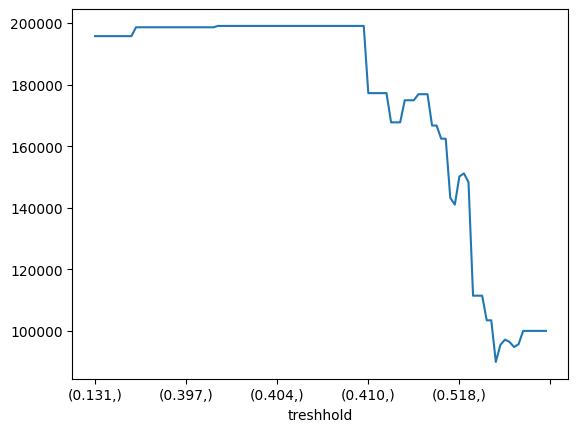

In [91]:
# Преобразуем все уровни индекса в строковый формат, затем обрезаем
index_levels = [heatmap.index.get_level_values(level).astype(str).str[:5] for level in range(heatmap.index.nlevels)]

# Создаем новый MultiIndex из обработанных уровней
heatmap.index = pd.MultiIndex.from_arrays(index_levels, names=heatmap.index.names)

# Построение графика!
heatmap.plot()